## test_postprocessing.ipynb
This notebook is meant to postprocess groundwater results from the test cases (setup_test.py) and run by Kevin Befus on MODFLOW using MTL water level.

By Emily Mongold 8 April 2025

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.warp import transform as warp_transform
from rasterio.transform import xy
import contextily as ctx
from rasterio.plot import plotting_extent
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.geometry import Point, LineString
import utm
import matplotlib.colors as colors

from regional_K.cpt_functions import create_mask_from_band, align_rasters, setup_grid, assign_elevation, get_groundwater_values, get_any_tiff_values

import warnings
warnings.filterwarnings('ignore')

### Cross sections

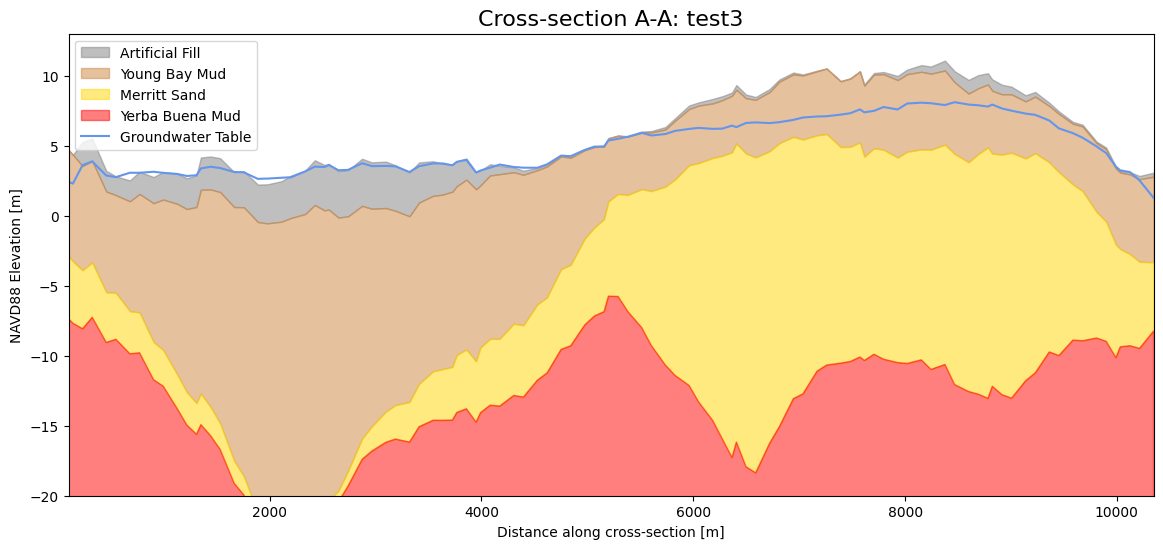

In [5]:
points = setup_grid(geoplot='./geojson/alameda_city.geojson')

## assign elevation to points
elev_tif = './Alameda_elevation.tif'
points['Latitude'] = points['lat']
points['Longitude'] = points['lon']
points = assign_elevation(points,elev_tif)
# Convert lat/lon to UTM (assuming EPSG:4326 -> UTM Zone 10N)
points['UTM_X'], points['UTM_Y'] = zip(*points.apply(lambda row: utm.from_latlon(row['lat'], row['lon'])[:2], axis=1))

# Load thickness layers and groundwater table as rasterio datasets
layers = {
    "fill": rasterio.open("./out_geotiffs/layer0_thick_m_test3.tif"),
    "ybm": rasterio.open("./out_geotiffs/layer1_thick_m_test3.tif"),
    "ms": rasterio.open("./out_geotiffs/layer2_thick_m_test3.tif"),
    "ybmud": rasterio.open("./out_geotiffs/layer3_thick_m_test3.tif"),
    "wt_depth": rasterio.open("./wtdepths_250130/alameda_0_MHHW_slr0.00m_Khtest3_10m_wtdepth_nofel.tif")
}

# Extract values from raster at each point location
for layer_name, dataset in layers.items():
    # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
    points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

# Define cross-section A-A
# LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

# Compute distances along cross-section
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
line_utm = LineString(utm_coords)

points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

# Filter points near the section line
points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))
points_near_line = points_near_line.sort_values('distance_along_line')
points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

# Plot cross-section
plt.figure(figsize=(14, 6))
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'],
    points_near_line['elevation'] - points_near_line['fill'],
    color='grey', alpha=0.5, label='Artificial Fill'
)
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['fill'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
    color='peru', alpha=0.5, label='Young Bay Mud'
)
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
    color='gold', alpha=0.5, label='Merritt Sand'
)
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
    points_near_line['elevation'] - 50,
    color='red', alpha=0.5, label='Yerba Buena Mud'
)

# Plot groundwater table
plt.plot(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['wt_depth'],
    color='cornflowerblue', linestyle='-', label='Groundwater Table'
)

plt.title("Cross-section A-A: test3", fontsize=16)
plt.xlabel("Distance along cross-section [m]")
plt.ylabel("NAVD88 Elevation [m]")
plt.xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
plt.ylim(-20, 13)
plt.legend()
plt.show()


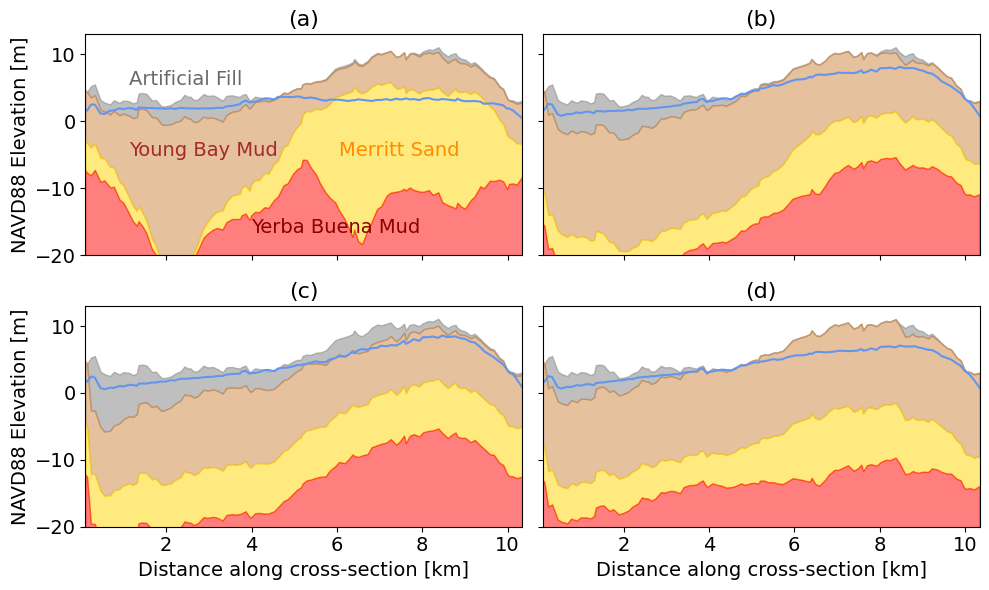

In [6]:
tests = ["test1", "test6", "test5", "test9"]
label = ['(a)', '(b)', '(c)', '(d)']
# make all tick labels font 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axes = axs.flatten()
for ind, test in enumerate(tests):
    # Load thickness layers and groundwater table as rasterio datasets
    layers = {
        "fill": rasterio.open(f"./out_geotiffs/layer0_thick_m_{test}.tif"),
        "ybm": rasterio.open(f"./out_geotiffs/layer1_thick_m_{test}.tif"),
        "ms": rasterio.open(f"./out_geotiffs/layer2_thick_m_{test}.tif"),
        "ybmud": rasterio.open(f"./out_geotiffs/layer3_thick_m_{test}.tif"),
        "wt_depth": rasterio.open(f"./wtdepths_250130/MTL/alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif")
    }
    ybmk = rasterio.open(f"./out_geotiffs/layer1_hK_mday_{test}.tif")
    ybmk = ybmk.read(1)
    # print(np.log10(ybmk[0][0]))
    # Extract values from raster at each point location
    for layer_name, dataset in layers.items():
        # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
        points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

    # Define cross-section A-A
    # LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
    section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

    # Compute distances along cross-section
    points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
    points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
    line_utm = LineString(utm_coords)
    
    points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

    # Filter points near the section line
    points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
    points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))
    points_near_line = points_near_line.sort_values('distance_along_line')
    points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

    # Plot cross-section
    ax = axes[ind]
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'],
        points_near_line['elevation'] - points_near_line['fill'],
        color='grey', alpha=0.5, label='Artificial Fill')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        color='peru', alpha=0.5, label='Young Bay Mud')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        color='gold', alpha=0.5, label='Merritt Sand')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        points_near_line['elevation'] - 50,
        color='red', alpha=0.5, label='Yerba Buena Mud')

    # Plot groundwater table
    ax.plot(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['wt_depth'],
        color='cornflowerblue', linestyle='-', label='Groundwater Table'
    )

    ax.set_title(label[ind], fontsize=16)
    # if ind.isin([0, 3]): does not work but make the same functionality
    if ind in [0, 2]:
        ax.set_ylabel("NAVD88 Elevation [m]", fontsize=14)
    else:
        ax.set_yticklabels([])
    if ind in [2, 3]:
        ax.set_xlabel("Distance along cross-section [km]", fontsize=14)
        ax.set_xticklabels([f"{int(x/1000)}" for x in ax.get_xticks()[1:]])
    else:
        ax.set_xticklabels([])
    ax.set_xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
    ax.set_ylim(-20, 13)
# plt.legend()
    # add labels to the first subplot as text on the figure
    if ind == 0:
        ax.text(0.1, 0.77, 'Artificial Fill', color='dimgrey', transform=ax.transAxes, fontsize=14)
        ax.text(0.1, 0.45, 'Young Bay Mud', color='brown', transform=ax.transAxes, fontsize=14)
        ax.text(0.58, 0.45, 'Merritt Sand', color='darkorange', transform=ax.transAxes, fontsize=14)
        ax.text(0.38, 0.1, 'Yerba Buena Mud', color='darkred', transform=ax.transAxes, fontsize=14)
plt.tight_layout()

# plt.savefig('./figures/test_cross_sections_MTL.png',dpi=1000, bbox_inches='tight',format='png')
# plt.savefig('./figures/test_cross_sections_MTL.pdf',dpi=1000, bbox_inches='tight',format='pdf')
plt.show()


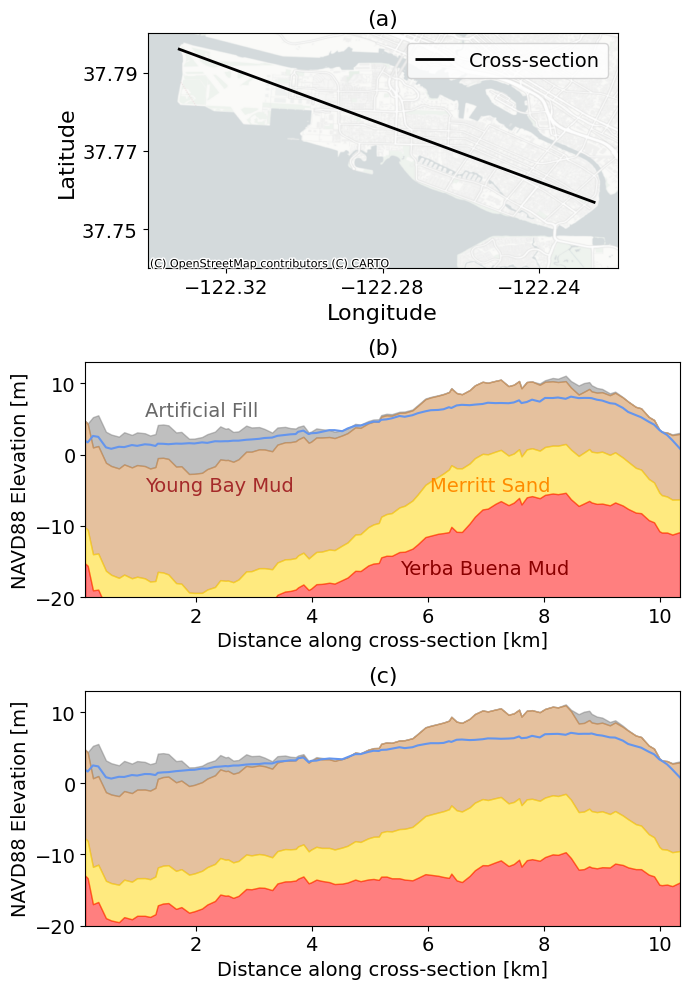

In [30]:
# plot vertically test 6 and test 9
from shapely.ops import transform
from pyproj import Transformer

# convert line_utm to lat/lon save as line
# line = LineString(utm.to_latlon(line_utm.xy[0], line_utm.xy[1], 10, 'N'))
line_latlon = transform(Transformer.from_crs("epsg:32610", "epsg:4326", always_xy=True).transform, line_utm)

fig, axs = plt.subplots(3, 1, figsize=(7, 10))
axes = axs.flatten()
tests = ["test6", "test9"]
labels = ['(a)', '(b)', '(c)']

# for the first subplot, make it be the map with the cross-section
ax = axs[0]
gpd.GeoSeries(line_latlon).plot(ax=ax, color='k', linewidth=2, label='Cross-section')
ax.set_xticks(ax.get_xticks()[1::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_ylim(37.74, 37.8)
ax.set_xlim(-122.34, -122.22)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.PositronNoLabels) # where is positron no labels? --CartoDB
ax.legend(fontsize=14)
# plt.title('Cross-Section Line and Points')
ax.set_xlabel('Longitude',fontsize=16)
ax.set_ylabel('Latitude',fontsize=16)
ax.set_title('(a)', fontsize=16)

for ind, test in enumerate(tests):
    ind = ind + 1
    # Load thickness layers and groundwater table as rasterio datasets
    layers = {
        "fill": rasterio.open(f"./out_geotiffs/layer0_thick_m_{test}.tif"),
        "ybm": rasterio.open(f"./out_geotiffs/layer1_thick_m_{test}.tif"),
        "ms": rasterio.open(f"./out_geotiffs/layer2_thick_m_{test}.tif"),
        "ybmud": rasterio.open(f"./out_geotiffs/layer3_thick_m_{test}.tif"),
        "wt_depth": rasterio.open(f"./wtdepths_250130/MTL/alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif")
    }
    ybmk = rasterio.open(f"./out_geotiffs/layer1_hK_mday_{test}.tif")
    ybmk = ybmk.read(1)
    # print(np.log10(ybmk[0][0]))
    # Extract values from raster at each point location
    for layer_name, dataset in layers.items():
        # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
        points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

    # Define cross-section A-A
    # LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
    section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

    # Compute distances along cross-section
    points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
    points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
    line_utm = LineString(utm_coords)

    points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

    # Filter points near the section line
    points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
    points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))/1000
    points_near_line = points_near_line.sort_values('distance_along_line')
    points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

    # Plot cross-section
    ax = axes[ind]
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'],
        points_near_line['elevation'] - points_near_line['fill'],
        color='grey', alpha=0.5, label='Artificial Fill')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        color='peru', alpha=0.5, label='Young Bay Mud')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        color='gold', alpha=0.5, label='Merritt Sand')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        points_near_line['elevation'] - 50,
        color='red', alpha=0.5, label='Yerba Buena Mud')
    
    # Plot groundwater table
    ax.plot(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['wt_depth'],
        color='cornflowerblue', linestyle='-', label='Groundwater Table'
    )

    # ax.set_title(label[ind], fontsize=16)
    # if ind.isin([0, 3]): does not work but make the same functionality
    ax.set_ylabel("NAVD88 Elevation [m]", fontsize=14)
    ax.set_title(label[ind], fontsize=16)
    if ind in [1,2]:
        ax.set_xlabel("Distance along cross-section [km]", fontsize=14)
        ax.set_xticklabels([f"{int(x)}" for x in ax.get_xticks()[1:]])
    else:
        ax.set_xticklabels([])
    ax.set_xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
    ax.set_ylim(-20, 13)
# plt.legend()
    # add labels to the first subplot as text on the figure
    if ind == 1:
        ax.text(0.1, 0.77, 'Artificial Fill', color='dimgrey', transform=ax.transAxes, fontsize=14)
        ax.text(0.1, 0.45, 'Young Bay Mud', color='brown', transform=ax.transAxes, fontsize=14)
        ax.text(0.58, 0.45, 'Merritt Sand', color='darkorange', transform=ax.transAxes, fontsize=14)
        ax.text(0.53, 0.1, 'Yerba Buena Mud', color='darkred', transform=ax.transAxes, fontsize=14)
plt.tight_layout()

plt.savefig('./figures/cross_sections_MTL.png',dpi=1000, bbox_inches='tight',format='png')
plt.savefig('./figures/cross_sections_MTL.pdf',dpi=1000, bbox_inches='tight',format='pdf')
plt.show()   


In [20]:
for layer_name, dataset in layers.items():
    dataset.close()

In [21]:
del layers, points_near_line, points_gdf

### Depths

In [22]:
budget_summary = pd.read_csv('./alameda_budget_summary.csv')
inputs = pd.read_csv('./input_params.csv', index_col=0)

folder = './wtdepths_250307/'
target_crs = "EPSG:4326"

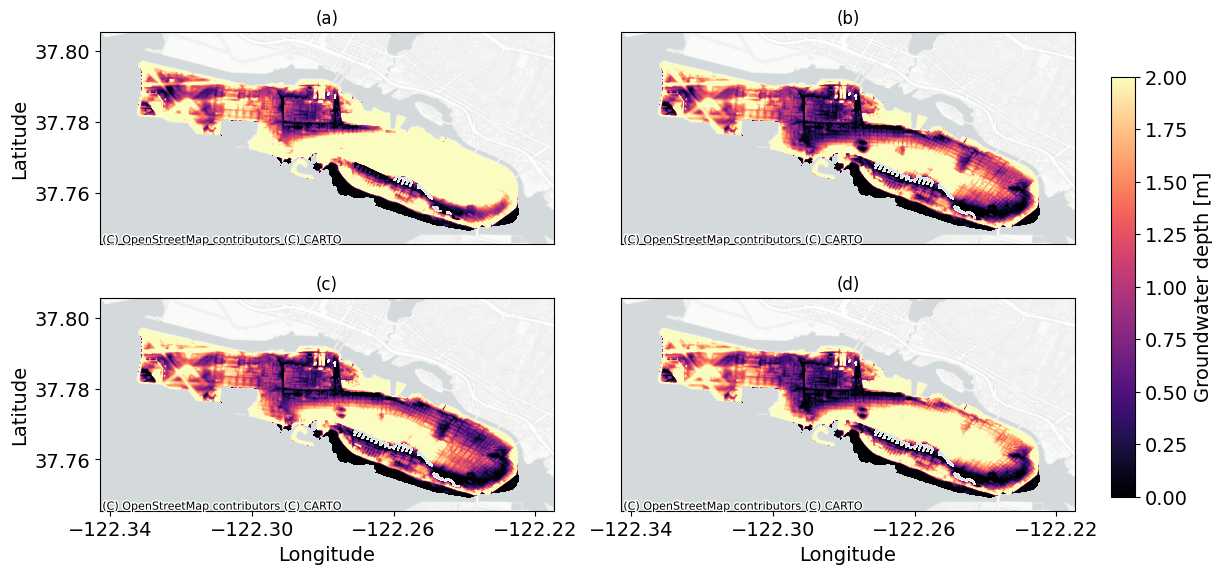

In [23]:
## plot the above just for 
tests = ["test1", "test6", "test5", "test9"]
label = ['(a)', '(b)', '(c)', '(d)']
# make all tick labels font 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axes = axs.flatten()
for ind, test in enumerate(tests):
    file = folder + 'alameda_0_MTL_slr0.00m_Kh' + test + '_10m_wtdepth_nofel.tif'
    with rasterio.open(file) as src:
        transform, width, height = calculate_default_transform(
            src.crs,         # source CRS
            target_crs,      # target CRS
            src.width,
            src.height,
            *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height})
        reprojected_data = np.empty((src.count, height, width), dtype=src.dtypes[0])
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=reprojected_data[i - 1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )
    band1 = reprojected_data[0]
    band1_masked = np.where(band1 < -1, np.nan, band1)  # mask out the no data values
    top_left = xy(transform, 0, 0, offset="ul")
    bottom_right = xy(transform, height-1, width-1, offset="lr")
    left, top = top_left
    right, bottom = bottom_right

    img = axes[ind].imshow(band1_masked, extent=(left, right, bottom, top), origin="upper", cmap="magma", vmin=0,vmax=2)
    axes[ind].set_title(label[ind])
    if ind in [0, 2]:
        axes[ind].set_ylabel("Latitude", fontsize=14)
    else:
        axes[ind].set_yticks([])
    if ind in [2, 3]:
        axes[ind].set_xlabel('Longitude', fontsize=14)
        axes[ind].set_xticks(axes[ind].get_xticks()[1::2])
    else:
        axes[ind].set_xticks([])

    ctx.add_basemap(axes[ind],crs=target_crs, source=ctx.providers.CartoDB.PositronNoLabels, zorder=-1)
plt.tight_layout()

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, label="Groundwater depth [m]")
cbar_ax.tick_params(labelsize=14)
cbar_ax.yaxis.label.set_size(14)

# plt.savefig('./figures/test_gw_depths_MTL.png', dpi=1000, format = 'png', bbox_inches='tight')
# plt.savefig('./figures/test_gw_depths_MTL.pdf', dpi=1000, format = 'pdf', bbox_inches='tight')

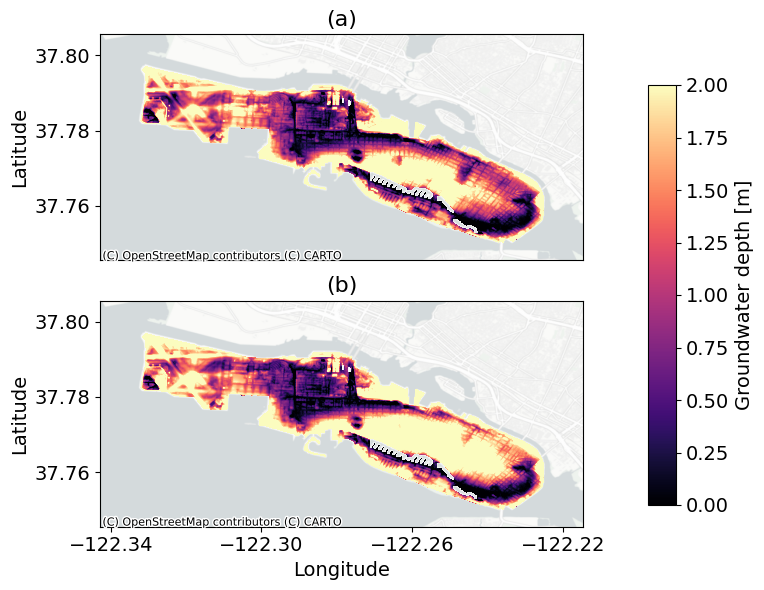

In [43]:
# plot the above just for tests 6 and 9
fig, axs = plt.subplots(2, 1, figsize=(7, 6))
axes = axs.flatten()
tests = ["test6", "test9"]

for ind, test in enumerate(tests):
    file = folder + 'alameda_0_MTL_slr0.00m_Kh' + test + '_10m_wtdepth_nofel.tif'
    with rasterio.open(file) as src:
        transform, width, height = calculate_default_transform(
            src.crs,         # source CRS
            target_crs,      # target CRS
            src.width,
            src.height,
            *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height})
        reprojected_data = np.empty((src.count, height, width), dtype=src.dtypes[0])
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=reprojected_data[i - 1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )
    band1 = reprojected_data[0]
    band1_masked = np.where(band1 < -1, np.nan, band1)  # mask out the no data values

    ## crop to just plot within the area of 'Alameda_shape.geojson'
    # Load the shapefile
    shapefile_path = './Alameda_shape.geojson'
    with fiona.open(shapefile_path) as shapefile:
        # Get the first feature (assuming it's a single polygon)
        feature = next(iter(shapefile))
        geometry = shape(feature['geometry'])
        # Get the bounds of the geometry
        minx, miny, maxx, maxy = geometry.bounds
        # Create a mask for the raster data
        mask = rasterio.features.geometry_mask([geometry], transform=transform, invert=True, out_shape=(height, width))

    # Apply the mask to the raster data
    band1_masked = np.where(mask, band1_masked, np.nan)

    top_left = xy(transform, 0, 0, offset="ul")
    bottom_right = xy(transform, height-1, width-1, offset="lr")
    left, top = top_left
    right, bottom = bottom_right

    img = axes[ind].imshow(band1_masked, extent=(left, right, bottom, top), origin="upper", cmap="magma", vmin=0,vmax=2)
    axes[ind].set_title(label[ind], fontsize=16)
    if ind in [0, 1]:
        axes[ind].set_ylabel("Latitude", fontsize=14)
    else:
        axes[ind].set_yticks([])
    if ind in [1]:
        axes[ind].set_xlabel('Longitude', fontsize=14)
        axes[ind].set_xticks(axes[ind].get_xticks()[1::2])
    else:
        axes[ind].set_xticks([])

    ctx.add_basemap(axes[ind],crs=target_crs, source=ctx.providers.CartoDB.PositronNoLabels, zorder=-1)
plt.tight_layout()

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax, label="Groundwater depth [m]")
cbar_ax.tick_params(labelsize=14)
cbar_ax.yaxis.label.set_size(14)

In [9]:
del band1_masked, band1, reprojected_data

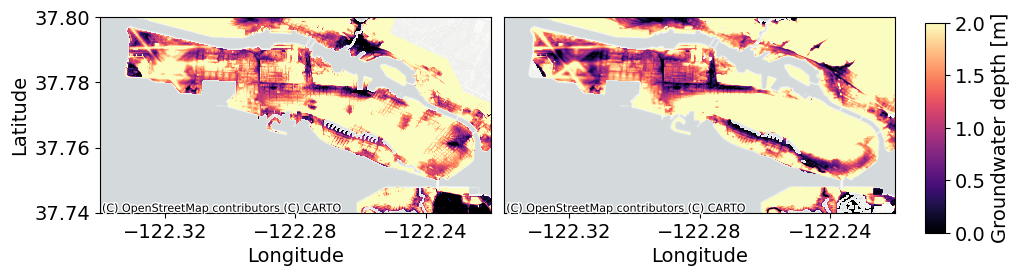

In [42]:
## make a plot like the above where the left is the empirical and right is homogeneous kh=1.0:
# homogeneous path: './gtif_base/Alameda_wt_lmsl_noghb_Kh1p0_slr0p00m.tif'
# empirical path: './Existing_DTW_reproj.tif'

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axes = axs.flatten()
for ind, test in enumerate(tests):
    if ind == 0:    
        file = './Existing_DTW_reproj.tif'
    else:
        file = './gtif_base/Alameda_wt_lmsl_noghb_Kh1p0_slr0p00m.tif'
    with rasterio.open(file) as src:
        transform, width, height = calculate_default_transform(
            src.crs,         # source CRS
            target_crs,      # target CRS
            src.width,
            src.height,
            *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height})
        reprojected_data = np.empty((src.count, height, width), dtype=src.dtypes[0])
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=reprojected_data[i - 1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )
    band1 = reprojected_data[0]
    if ind == 0:
        band1 = band1/3.2808  # convert from feet to meters
    band1_masked = np.where(band1 < -1, np.nan, band1)  # mask out the no data values
    top_left = xy(transform, 0, 0, offset="ul")
    bottom_right = xy(transform, height-1, width-1, offset="lr")
    left, top = top_left
    right, bottom = bottom_right

    img = axes[ind].imshow(band1_masked, extent=(left, right, bottom, top), origin="upper", cmap="magma", vmin=0,vmax=2)
    # axes[ind].set_title(label[ind])
    if ind in [0, 2]:
        axes[ind].set_ylabel("Latitude", fontsize=14)
        # axes[ind].set_yticks(axes[ind].get_yticks()[1::2])
    else:
        axes[ind].set_yticks([])
    axes[ind].set_xlabel('Longitude', fontsize=14)
    axes[ind].set_xticks([-122.32,-122.28,-122.24])

    # make the plot limits to be -122.34 to -122.22 and 37.75 to 37.8 
    axes[ind].set_xlim(-122.34, -122.22)
    axes[ind].set_ylim(37.74, 37.8)

    ctx.add_basemap(axes[ind],crs=target_crs, source=ctx.providers.CartoDB.PositronNoLabels, zorder=-1)
plt.tight_layout()

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, label="Groundwater depth [m]")
cbar_ax.tick_params(labelsize=14)
cbar_ax.yaxis.label.set_size(14)


#### Re-project and save TIFs

In [10]:
## write the reprojected data to a new folder
output_folder='./wtdepths_2503007_reprojected/'
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

for test in inputs['names']:
    input_file = folder + f'/alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif'
    output_file = output_folder + f'alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif'

    with rasterio.open(input_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)

        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        reprojected_data = np.empty((src.count, height, width), dtype=src.dtypes[0])

        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=reprojected_data[i - 1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )
        # Save the reprojected raster
        with rasterio.open(output_file, 'w', **kwargs) as dst:
            dst.write(reprojected_data)

In [11]:
del reprojected_data

### Comparisons

In [12]:
file = "./Existing_DTW_Groundwater1.tif"
with rasterio.open(file) as src:
    dtw_band = src.read(1)
    transform = src.transform
    crs = src.crs
# mask out points that are < -1000
dtw_band[dtw_band < -1000] = np.nan

newfile = "./Existing_DTW_reproj.tif"

target_crs = 'EPSG:4326'
# reproject to newfile with dest_crs
with rasterio.open(file) as src:
    # Read the input data
    data = src.read(1, masked=True)  # Considering data is in the 1st band
    data_masked = np.ma.masked_invalid(data)
    old_nodata_value = src.nodata
    data_masked = np.where(data_masked == old_nodata_value, np.nan, data_masked)
    transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)

    profile = src.profile
    profile.update(
        crs=target_crs,
        transform=transform,
        width=width,
        height=height,
        dtype='float32',  # Set the desired data type for the output dataset ('ComplexInt16' to 'float32')
        nodata=np.nan,  # Set the new nodata value for the output dataset
        driver='GTiff'
    )

    # Perform the reprojection and directly write to the output GeoTIFF
    with rasterio.open(newfile, 'w', **profile, BIGTIFF='YES', TILED='YES', COPY_SRC_OVERVIEWS='YES', COMPRESS='DEFLATE') as dst:
        reproject(
            source=data_masked,
            src_transform=src.transform,
            src_crs=src.crs,
            destination=rasterio.band(dst, 1),
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,  
            dst_nodata=np.nan  # Set the new nodata value for the output dataset
        )

del dtw_band, data_masked, data

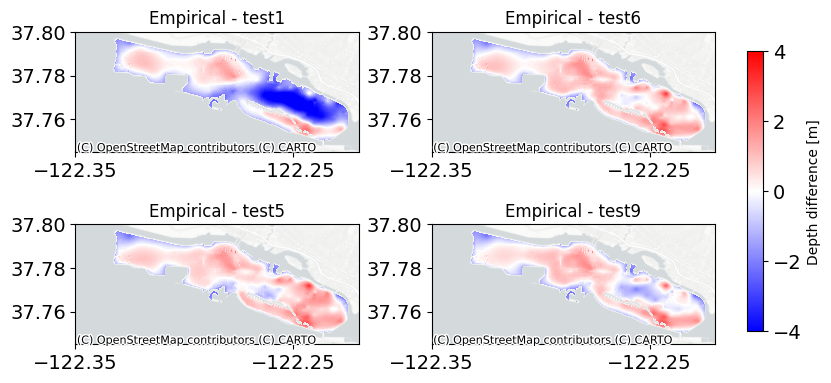

In [13]:
## calculate the differences
## plot these differences but just for the 6 in tests
folder = './wtdepths_250307/'
tests = ["test1", "test6", "test5", "test9"]
labels = ['(a)', '(b)','(c)', '(d)']

fig, axes = plt.subplots(2, 2, figsize=(8, 4))
axes = axes.flatten()
for ind, test in enumerate(tests):
    ax = axes[ind]
    test1_path = os.path.join(folder, f'alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif')
    depth_band, aligned_test_band, target_transform = align_rasters(newfile, test1_path)

    aligned_test_band[aligned_test_band == -9999] = np.nan
    depth_band[depth_band <= -9999] = np.nan
    # Calculate the difference, setting NaN where one or both arrays have no data
    difference = np.where(
        np.isnan(depth_band) | np.isnan(aligned_test_band), 
        np.nan, 
        depth_band*0.3048 - aligned_test_band
    )
    extent = rasterio.plot.plotting_extent(aligned_test_band, target_transform)
    # Visualize the result
    img = ax.imshow(difference, cmap='bwr',extent=extent, vmin=-4, vmax=4, zorder=10)  # convert feet to m by multiplying by 0.3048
    ax.set_title('Empirical - '+test)
    ax.set_xlim(-122.34, -122.22)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_ylim(37.745, 37.8)
    ctx.add_basemap(ax=ax, crs='EPSG:4326', source=ctx.providers.CartoDB.PositronNoLabels,zorder=-1)
fig.tight_layout()
plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, label="Depth difference [m]")
plt.show()


In [ ]:
## make the plot from above but make a fourth column with baseline data from Kh = 0.1 and Kh = 1.0

fig,axes = plt.subplots(2, 4, figsize=(16, 4))
axes = axes.flatten()

# saved_diffs = {}
tests = ["test1", "test6", "test5", "Kh1p0", "test3", "test7", "test9", "Kh0p1"]

for ind,test in enumerate(tests):
    print(f"Processing {test}...")
    if test.startswith("test"):
        file = folder + f'alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif'
    else:
        file = './gtif_base/Alameda_wt_lmsl_noghb_' + test + '_slr0p00m.tif'

    ax = axes[ind]
    depth_band, aligned_test_band, target_transform = align_rasters(newfile, file)
    
    # Replace nodata values with np.nan
    aligned_test_band[aligned_test_band == -9999] = np.nan
    depth_band[depth_band <= -9999] = np.nan
    
    # Calculate the difference: (empirical - test)
    difference = np.where(
        np.isnan(depth_band) | np.isnan(aligned_test_band),
        np.nan,
        depth_band * 0.3048 - aligned_test_band
    )
    difference = difference.astype(np.float16)  # or np.float16 if less precision is acceptable

    c_lim = 3
    extent = plotting_extent(aligned_test_band, target_transform)
    img = ax.imshow(difference, cmap='PRGn', extent=extent, vmin=-c_lim, vmax=c_lim, zorder=10)  # bwr
    
    ax.set_title('Empirical - ' + test, fontsize=14)
    ax.set_xlim(-122.34, -122.22)
    ax.set_ylim(37.745, 37.8)
    if ind in [0,4]:
        ax.set_ylabel('Latitude',fontsize=14)
    else:
        ax.set_yticks([])
    if ind in [4,5,6,7]:
        ax.set_xlabel('Longitude',fontsize=14)
        # ax.set_xticks(ax.get_xticks()[::2])
    else:
        ax.set_xticks([])
    ax.set_xlim(-122.34, -122.22)
    ax.set_ylim(37.745, 37.8)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.PositronNoLabels)

plt.tight_layout(h_pad=2)
plt.subplots_adjust(right=0.92)  
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, label="Depth difference [m]")
plt.show()


Processing test1...


In [ ]:
file = "./Alameda_GWT.geojson"
gdf = gpd.read_file(file)
# remove any points that are < -1000
gdf = gdf[gdf['data'] > -1000]
gdf['data'] = gdf['data']*0.3048
for ind, test in enumerate(tests):
    if "test" in test:
        file = folder + f'alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif'
    else:
        file = './gtif_base/Alameda_wt_lmsl_noghb_' + test + '_slr0p00m.tif'
    
    depths = get_any_tiff_values(file, gdf['geometry'].y.tolist(), gdf['geometry'].x.tolist())
    gdf[test] = depths
gdf = gdf.dropna()
gdf[gdf['Kh0p1']==-500]

# store the indices where Kh0p1 and Kh1p0 are -500
idx01 = gdf[gdf['Kh0p1']==-500].index
idx10 = gdf[gdf['Kh1p0']==-500].index


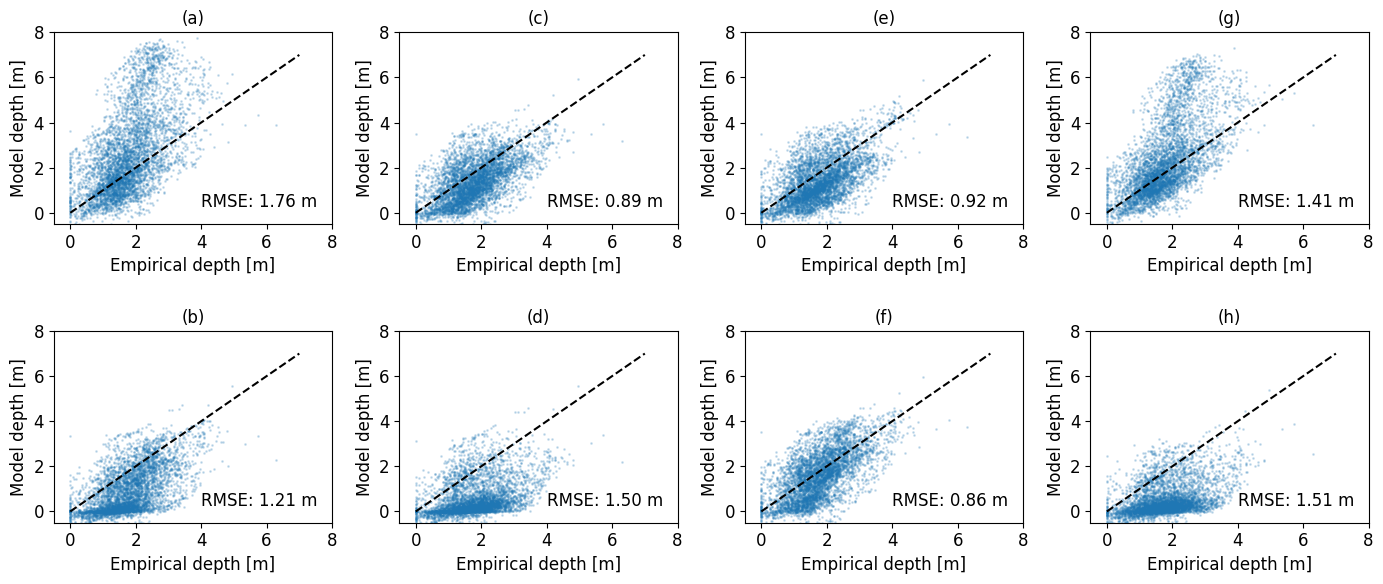

In [ ]:
## calculate and print the rmse on the plot
## make all font sizes 12
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)

labels = ['(a)', '(c)', '(e)', '(g)', '(b)', '(d)', '(f)', '(h)']
fig,axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for ind, test in enumerate(tests):
    ax = axes[ind]

    # find rmse between empirical and test
    rmse = np.sqrt(np.mean((gdf[gdf[test]>-400]['data'] - gdf[gdf[test]>-400][test])**2))

    ax.scatter(gdf[gdf[test]>-400]['data'], gdf[gdf[test]>-400][test], alpha=0.2, s=1)
    ax.plot([0,7],[0,7], color='k', linestyle='--')
    ax.text(4, 0.25, f'RMSE: {rmse:.2f} m', fontsize=12)
    ax.set_xlim(-0.5,8)
    ax.set_xticks([0,2,4,6,8])
    ax.set_yticks([0,2,4,6,8])
    ax.set_ylim(-0.5,8)
    ax.set_xlabel('Empirical depth [m]')
    ax.set_ylabel('Model depth [m]')
    ax.set_title(labels[ind])
plt.tight_layout(h_pad=2)
# plt.savefig('figures/wd_emp_scatter_MTL.png', dpi=1000, bbox_inches='tight',format='png')
# plt.savefig('figures/wd_emp_scatter_MTL.pdf', dpi=1000, bbox_inches='tight',format='pdf')
plt.show()

In [ ]:
original_prgn = plt.cm.get_cmap('PRGn', 256)
scaled_colors = np.empty((256, 4))
original_positions = np.linspace(-3, 3, 256)  # Original positions from -3 to 3
new_positions = np.linspace(-1, 3, 256)       # New positions from -1 to 3
for i in range(256):
    # Find the closest index in the original positions
    idx = (np.abs(original_positions - new_positions[i])).argmin()
    scaled_colors[i] = original_prgn(idx / 255)

# Create a new LinearSegmentedColormap
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("ScaledPRGn", scaled_colors)



In [ ]:
reference_file_path = folder + f'alameda_0_MTL_slr0.00m_Khtest1_10m_wtdepth_nofel.tif'
mask = create_mask_from_band(reference_file_path)

with rasterio.open(file) as src:
    dtw_band = src.read(1)
    transform = src.transform
    crs = src.crs
# mask out points that are < -1000
dtw_band[dtw_band < -1000] = np.nan


fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 3, figure=fig)

# Create subplots
# The left column spans the first two of the three virtual columns
axs = [fig.add_subplot(gs[i, :2]) for i in range(5)]
axs_right = [fig.add_subplot(gs[i, 2]) for i in range(5)]

lhs_titles = ['(d)', '(f)', '(h)']
tests = ["test1", "test6", "test9"]
for i, ax in enumerate(axs):
    if i == 0:
        img = ax.imshow(dtw_band*0.3048, cmap='magma', extent=rasterio.plot.plotting_extent(dtw_band, transform),vmin=0, vmax=2)
        ax.set_xlim(-122.34, -122.22)
        ax.set_ylim(37.745, 37.8)
        ax.set_xticks(ax.get_xticks()[::2])
        ax.set_yticks(ax.get_yticks()[::2])
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326',zorder=-1)
        ax.set_title('(a)')
    elif i == 1:
        file = './gtif_base/Alameda_wt_lmsl_noghb_Kh1p0_slr0p00m.tif'
        depth_band, aligned_test_band, target_transform = align_rasters(newfile, file)
        aligned_test_band[aligned_test_band == -9999] = np.nan
        depth_band[depth_band <= -9999] = np.nan
        difference = np.where(np.isnan(depth_band) | np.isnan(aligned_test_band),np.nan,depth_band * 0.3048 - aligned_test_band)
        difference = difference.astype(np.float16)
        extent = plotting_extent(aligned_test_band, target_transform)
        img = ax.imshow(difference, cmap='PRGn', extent=extent, vmin=-c_lim, vmax=c_lim)
        ax.set_xlim(-122.34, -122.22)
        ax.set_ylim(37.745, 37.8)
        ax.set_xticks(ax.get_xticks()[::2])
        ax.set_yticks(ax.get_yticks()[::2])
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326',zorder=-1)
        ax.set_title('(b)')
    else: 
        file = folder + f'alameda_0_MTL_slr0.00m_Kh{tests[i-2]}_10m_wtdepth_nofel.tif'
        depth_band, aligned_test_band, target_transform = align_rasters(newfile, file)
        aligned_test_band[aligned_test_band == -9999] = np.nan
        depth_band[depth_band <= -9999] = np.nan
        difference = np.where(np.isnan(depth_band) | np.isnan(aligned_test_band),np.nan,depth_band*0.3048 - aligned_test_band)
        extent = plotting_extent(aligned_test_band, target_transform)
        img = ax.imshow(difference, cmap='PRGn', extent=extent, vmin=-c_lim, vmax=c_lim)
        ax.set_xlim(-122.34, -122.22)
        ax.set_ylim(37.745, 37.8)
        ax.set_xticks(ax.get_xticks()[::2])
        ax.set_yticks(ax.get_yticks()[::2])
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326',zorder=-1)
        ax.set_title(lhs_titles[i-2])

rhs_titles = ['(c)', '(e)', '(g)', '(i)']
tests = ["Kh1p0","test1", "test6", "test9"]

for i , ax in enumerate(axs_right):
    if i == 0:
        depth_sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=0, vmax=2))
        depth_sm._A = []

        # Delta colorbar
        delta_sm = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(vmin=-c_lim, vmax=c_lim))
        delta_sm._A = []

        # Turn off the ghost axis in axs[0, 1]
        ax.axis('off')

        # Adjust the colorbars to be chunkier by changing the 'fraction'
        delta_cbar = fig.colorbar(delta_sm, ax=ax, orientation='vertical', fraction=0.4, pad=0.02,aspect=5)
        delta_cbar.set_label('Difference in Depth \n from Empirical [m]')

        depth_cbar = fig.colorbar(depth_sm, ax=ax, orientation='vertical', fraction=0.8, pad=0.02,aspect=5)
        depth_cbar.set_label('Depth to \nGroundwater [m]')

    else:
        test = tests[i-1]
        rmse = np.sqrt(np.mean((gdf[gdf[test]>-400]['data'] - gdf[gdf[test]>-400][test])**2))
        ax.scatter(gdf[gdf[test]>-400]['data'], gdf[gdf[test]>-400][test], alpha=0.2, s=1)
        ax.plot([0,7],[0,7], color='k', linestyle='--')
        ax.text(4, 0.25, f'RMSE: {rmse:.2f} m', fontsize=12)
        ax.set_xlim(-0.5,8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_yticks([0,2,4,6,8])
        ax.set_ylim(-0.5,8)
        ax.set_xlabel('Empirical depth [m]')
        ax.set_ylabel('Model depth [m]')
        ax.set_title(rhs_titles[i-1])
    
plt.tight_layout()
# plt.savefig('figures/empirical_comparison.png', dpi=1000, bbox_inches='tight',format='png')
# plt.savefig('figures/empirical_comparison.pdf', dpi=1000, bbox_inches='tight',format='pdf')
plt.show()


NameError: name 'folder' is not defined